In [1914]:
import pandas as pd
import os
import csv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import catboost
from numpy import percentile
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

In [1915]:
RANDOM_SEED = 42

# The maximum number of words to be used. (most frequent)
MAX_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 10

In [1916]:
def data_outlier(columns_list, df):

    data_out = pd.DataFrame(data = {'name': [], 'count': [], 'min': [], 'mean': [], 'max': [], 
                                    'low_range': [], 'upper_range': [], 'out_count': []
                                   })
    for column_name in columns_list:
        perc25 = percentile(df[column_name], 25)
        perc75 = percentile(df[column_name], 75)
        iqr = perc75 - perc25
        low_range = perc25 - 1.5 * iqr
        upper_range = perc75 + 1.5 * iqr
        out_count = df[column_name].apply(
            lambda x: None if x < low_range or x > upper_range else x).isna().sum()
        
        to_append = [column_name, df[column_name].count(), round(df[column_name].min(), 2), 
                     round(df[column_name].mean(), 2), round(df[column_name].max(), 2), 
                     round(low_range, 2), round(upper_range, 2), out_count]
        data_out_length = len(data_out)
        data_out.loc[data_out_length] = to_append
    
    data_out = data_out.set_index('name')
        
    return data_out

In [1917]:
# Рассмотрим как распределены числовые признаки в трейне

def train_hist_plot(column_name, df_train):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    new_series_log = np.log(df_train[column_name] + 1)

    ax[0].hist(df_train[column_name], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(column_name)

    ax[1].hist(new_series_log, rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of ' + column_name)

    plt.show()
    
def test_hist_plot(column_name, df_test):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    new_series_log = np.log(df_test[column_name] + 1)

    ax[0].hist(df_test[column_name], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(column_name)

    ax[1].hist(new_series_log, rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of ' + column_name)

    plt.show()

In [1918]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [1919]:
def street_replace(df, st_tupl):

  # Функция замены коротких синонимов на полные названия и удаление дубликатов

  df['street'] = df['street'].str.replace(rf'\b{st_tupl[0]}\b', st_tupl[1]).str.replace(rf'\b{st_tupl[1]}\b \b{st_tupl[1]}\b', st_tupl[1])
  df['street'] = df['street'].str.replace('  ', ' ').str.strip()

  # print(f'replace {st_tupl[0]} to {st_tupl[1]}')



def del_dropwords_street(df, dropword):

  # Удаляем dropword из признака street
  df['street'] = df['street'].str.replace(rf'\b{dropword}\b', '').str.replace(r'  ', ' ').str.strip()

  print(f"Drop {dropword}")

In [1920]:
def preproc_data(df_input, num_features, cat_features):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    ################### Numerical Features ##############################################################

    scaler = StandardScaler()
    
    for feature in num_features:
         df_output[feature] = scaler.fit_transform(df_output[feature].values.reshape(-1, 1))


    ################### Categorical Features ##############################################################

    for column in cat_features:
         df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=cat_features, dummy_na=False)

    return df_output



In [1921]:
# df = pd.read_csv("/data_new.csv", sep=",", quoting=csv.QUOTE_ALL, encoding='utf-8')

df = pd.read_csv("data_new.csv")

In [1922]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [1923]:
df.shape

(377185, 18)

In [1924]:
df[df['target'].isna()].shape

(2481, 18)

In [1925]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [1926]:
print("Percent NULL values\n")
round(df.isna().sum() / df.shape[0] * 100, 2)

Percent NULL values



status          10.58
private pool    98.89
propertyType     9.21
street           0.00
baths           28.19
homeFacts        0.00
fireplace       72.66
city             0.01
schools          0.00
sqft            10.76
zipcode          0.00
beds            24.20
state            0.00
stories         39.96
mls-id          93.39
PrivatePool     89.31
MlsId           17.73
target           0.66
dtype: float64

Удаляем столбцы, где процент NULL значений больше 40%

In [1927]:
df.drop(['private pool', 'fireplace', 'mls-id', 'PrivatePool'], axis=1, inplace=True)

In [1928]:
df.nunique()

status             159
propertyType      1280
street          337076
baths              229
homeFacts       321009
city              2026
schools         297365
sqft             25405
zipcode           4549
beds              1184
state               39
stories            348
MlsId           232944
target           43939
dtype: int64

status

In [1929]:
df['status'] = df['status'].str.lower()

In [1930]:
import string
string.punctuation
string.digits

'0123456789'

In [1931]:
df['status'] = df['status'].str.replace('[{}]'.format(string.punctuation), ' ').str.replace('[{}]'.format(string.digits), ' ').apply(lambda x: " ".join(str(x).split()))
df['status'] = df['status'].apply(lambda x: None if x is None else None if str(x) == 'nan' else x)
df['status'].value_counts(dropna=False)

for sale                                199571
active                                  105207
NaN                                      39918
foreclosure                               6769
new construction                          5475
                                         ...  
pending sh                                   1
conditional contract                         1
under contract taking back up offers         1
backup                                       1
pending w escape clause                      1
Name: status, Length: 104, dtype: int64

In [1932]:
df['status'].nunique()

103

In [1933]:
df['status'].isna().sum()

39918

propertyType 

In [1934]:
df['propertyType'].sample(10)

75810                  condo
226345             townhouse
177082              lot/land
290391    single-family home
197736    single-family home
63313     single-family home
168228                 condo
106387              Bungalow
251752         Single Family
179266                 condo
Name: propertyType, dtype: object

In [1935]:
df['propertyType'] = df['propertyType'].str.lower()
df['propertyType'] = df['propertyType'].str.replace('[{}]'.format(string.punctuation), ' ').apply(lambda x: " ".join(str(x).split()))
df['propertyType'] = df['propertyType'].str.replace('one', '1').str.replace('two', '2')

In [1936]:
df['propertyType'].value_counts()[20:40]

contemporary modern           1010
apartment                      922
2 stories                      911
mfd mobile home                792
single detached                751
detached 2 story               638
2 story                        596
transitional                   560
cooperative                    535
florida                        530
bungalow                       442
farms ranches                  371
garden home                    305
cape cod                       281
2 stories traditional          280
spanish mediterranean          272
other style                    249
1 story traditional            238
other                          232
condo townhome traditional     225
Name: propertyType, dtype: int64

In [1937]:
df['stories_dop'] = df['propertyType'].str.findall(r'[a-z0-9]+ story|[a-z0-9]+ stories').apply(lambda x: None if len(x) == 0 else x[-1])
#.str.replace('one', '1').str.replace('two', '2')
df['stories_dop'].value_counts(dropna=False)

NaN          369527
1 story        4440
2 stories      1558
2 story        1466
3 stories       134
8 stories        38
7 stories        15
3 story           6
5 story           1
Name: stories_dop, dtype: int64

In [1938]:
set_story = set(df['stories_dop'].dropna())
for y in set_story:
  df['propertyType'] = df['propertyType'].str.replace(y, '')

In [1939]:
df[df['propertyType'].str.contains('home')]['propertyType'].value_counts()

single family home                                               123934
condo townhome row home co op                                      7701
multi family home                                                  1501
mfd mobile home                                                     792
garden home                                                         305
                                                                  ...  
condo townhome hi rise contemporary modern mid century modern         1
condo townhome hi rise resort property contemporary modern            1
condo townhome contemporary modern mediterranean split level          1
condo townhome single detached split level traditional                1
condo townhome designated historical home hi rise loft                1
Name: propertyType, Length: 137, dtype: int64

In [1940]:
df['propertyType'] = df['propertyType'].str.replace('home', '')
df['propertyType'] = df['propertyType'].apply(lambda x: None if x == '' else
                                              None if str(x) == 'nan' else 
                                              None if str(x) == 'None' else " ".join(str(x).split()))

In [1941]:
df['propertyType'].nunique()

1112

In [1942]:
df['propertyType'].value_counts(dropna=False)

single family                                       186803
condo                                                42530
NaN                                                  38211
lot land                                             20552
townhouse                                            18401
                                                     ...  
other patio traditional                                  1
lake house single detached mediterranean                 1
cape cod craftsman custom                                1
single detached early american traditional tudor         1
contemporary modern high rise ranch                      1
Name: propertyType, Length: 1113, dtype: int64

street

In [1943]:
df['street'].value_counts(dropna=False)[1200:]

7270 W Yale Ave                          3
922 Armada Dr                            3
4808 Wayne Ct                            3
2618 Princeton St                        3
10314 Glenburn Ln                        3
                                        ..
14000 SW 21st St                         1
NW 79th Loop                             1
English St                               1
411 Bergen Ave                           1
Buildable plan: Gannes Republic Creek    1
Name: street, Length: 335877, dtype: int64

In [1944]:
df['street'] = df['street'].str.lower()
df['street'] = df['street'].apply(lambda x: None if 'not disclosed' in str(x) else 
                                  None if 'undisclosed' in str(x) else
                                  None if 'not available' in str(x) else
                                  None if 'unknown' in str(x) else str(x))

In [1945]:
df.loc[(df['street'].isna()==False) & (df['street'].str.contains(r'mls ')), 'street'] = None

In [1946]:
punct = string.punctuation
df['street'] = df['street'].str.replace('[{}]'.format(string.punctuation), ' ').str.replace(r'\b[0-9]+\b', '').str.replace('  ', ' ').str.strip()

In [1947]:
street_list_tuple = [('st', 'street'), ('dr', 'drive'), ('ave', 'avenue'), ('rd', 'road'), ('rdg', 'ridge'), ('blvd', 'boulevard'), ('pkwy', 'parkway'), 
                   ('cir', 'circle'), ('hwy', 'highway'), ('ln', 'lane'), ('lndg', 'landing'), ('trl', 'trail'), ('ter', 'terrace'), ('ct', 'court'), 
                   ('crk', 'creek'), ('pl', 'place'), ('rds', 'roads'), ('bnd', 'bend'), ('fls', 'falls'), ('clf', 'cliff'), ('clfs', 'cliff'), ('mtn', 'mountain'), 
                   ('crst', 'crest'), ('hl', 'hill'), ('ml', 'mill'), ('mnr', 'manor'), ('hts', 'heights')]       
                          

In [1948]:
# for x in street_list_tuple:
#   street_replace(df, x)

In [1949]:
dropwords = ['lot', 'lots', 'collections', 'collection', 'plan', 'apt', 'unit', 'buildable', 'the']

# for x in dropwords:
#   del_dropwords_street(df, x)

In [1950]:
# Удаляем мусор из строк, чтобы легче паттерны было выделять
df['street'] = df['street'].str.replace(r'\b[a-z]{1,2}\b', '').str.replace('  ', ' ').str.strip()
df['street'] = df['street'].str.replace(r'\b[0-9]+[a-z]\b', '').str.replace(r'\b[a-z]+[0-9]\b', '').str.replace(r'\b[0-9]+ft\b', '')
df['street'] = df['street'].str.replace(r'  ', ' ').str.strip()

In [1951]:
df['street'] = df['street'].apply(lambda x: None if x is None else
                                  None if x.strip() == '' else x)

In [1952]:
df['street'].sample(10)

83322       southwest pkwy
135296       applewood cir
14189              sharman
65966                258th
334533     towers park apt
362159             brixton
139239    lancaster newark
126501            bellfort
77646            miami ave
94331            applegate
Name: street, dtype: object

baths

In [1953]:
df['baths'] = df['baths'].apply(lambda x: None if x is np.nan else x)
df['baths'].value_counts(dropna=False)

NaN              106338
2 Baths           52466
3 Baths           35506
2                 20452
2.0               16576
                  ...  
42 Baths              1
34.0                  1
16 ba                 1
21 Baths              1
1-0 / 1-0 / 1         1
Name: baths, Length: 230, dtype: int64

In [1954]:
punct = '~—\-:'

In [1955]:
df['baths'] = df['baths'].str.lower().str.replace('[a-z]+\.?', '').str.replace(',', '.').str.replace('[{}]'.format(punct), ' ')
df['baths'] = df['baths'].apply(lambda x: None if str(x).strip() =='' else x)

In [1956]:
df['baths_new'] = df['baths'].str.findall('[0-9]+\.?[0-9]*')
df['baths_new'] = df['baths_new'].apply(lambda x: None if x is None else x[0]).astype(float)
df['baths_new'].value_counts()

# df['baths_new'].to_csv('out.csv')
# ванна 0.5 проверить

2.0     103519
3.0      66683
4.0      26333
1.0      17787
2.5      13786
         ...  
1.8          1
64.0         1
14.5         1
0.5          1
42.0         1
Name: baths_new, Length: 84, dtype: int64

city

In [1957]:
df['city'] = df['city'].str.lower().str.strip()
df['city'] = df['city'].str.replace('\-', ' ')

In [1958]:
df['city'] = df['city'].str.replace(' city', '').str.replace(' town+[a-z]*', '')
df['city'] = df['city'].str.replace('st\.', 'saint').str.replace(' twp.', '').str.replace('e. ', '').str.replace('ft.', 'fort').str.replace('s.a.', 'san antonio')
df['city'] = df['city'].str.replace(' twp', '').str.replace(' vlg', ' village')
df['city'] = df['city'].str.replace(' hts', 'heights').str.replace(' pt', 'point').str.replace('pt ', 'port ')
df['city'] = df['city'].str.replace('^st ', 'saint ')

In [1959]:
df.loc[(df['city'].isna()==False) & (df['city'].str.contains('san antonio')), 'city'] = 'san antonio'

In [1960]:
df['city'] = df['city'].str.replace('p c ', 'panama ').str.replace('^n ', 'north ').str.replace("town 'n' country", 'town north country')
df['city'] = df['city'].str.replace('nyork', 'new york').str.replace('nyc', 'new york')
df['city'] = df['city'].str.replace('bed-stuy', 'brooklyn').str.replace('collegepoint', 'college point')
df['city'] = df['city'].str.replace('othvalue [ a-z]*', 'other')

In [1961]:
df['city'] = df['city'].apply(lambda x: " ".join(str(x).split())).str.strip()
df['city'] = df['city'].apply(lambda x: None if x is None else None if str(x) == '' else x)

In [1962]:
df['city'].value_counts(dropna=False)

san antonio         30033
houston             24442
miami               15528
jacksonville        10032
dallas               8858
                    ...  
eads                    1
city center             1
commercial point        1
rainbow valley          1
beulah                  1
Name: city, Length: 1784, dtype: int64

sqft

In [1963]:
df['sqft'].value_counts()

0                                          11854
1,200 sqft                                   839
1,000 sqft                                   654
1,100 sqft                                   573
1,800 sqft                                   563
                                           ...  
10,160 sqft                                    1
3634                                           1
Total interior livable area: 8,310 sqft        1
122,606 sqft                                   1
89,340 sqft                                    1
Name: sqft, Length: 25405, dtype: int64

In [1964]:
df['sqft'] = df['sqft'].apply(lambda x: None if x is np.nan else x)

In [1965]:
df['sqft'] = df['sqft'].str.replace('[a-z ]*: ', '')
df['sqft'] = df['sqft'].str.replace('-','').str.replace('[A-Za-z]+','').str.replace(',','')

In [1966]:
df['sqft'] = df['sqft'].str.strip().apply(lambda x: None if x is None else 
                                          None if x == '' else int(x))

In [1967]:
df['sqft'].value_counts(dropna=False)

NaN         41397
0.0         11854
1200.0       1426
1000.0       1027
1500.0       1014
            ...  
8966.0          1
11089.0         1
123275.0        1
44351.0         1
32767.0         1
Name: sqft, Length: 9898, dtype: int64

zipcode

In [1968]:
df['zipcode'].value_counts()

32137         2141
33131         1563
34747         1488
78245         1390
34759         1333
              ... 
5940             1
33785            1
27610-4307       1
14785            1
27703-8355       1
Name: zipcode, Length: 4549, dtype: int64

In [1969]:
# Приведем все значения к 5-значному формату

df['zipcode'] = df['zipcode'].str.replace('\-[0-9]*', '').apply(lambda x: None if x is None else 
                                                                None if x == '' else 
                                                                ('0000' + str(x))[-5:])

beds

In [1970]:
df['beds'] = df['beds'].apply(lambda x: None if x is np.nan else x).str.lower()

In [1971]:
df['beds'].value_counts(dropna=False)

NaN           91282
3 beds        53459
4 beds        35418
3             31406
2 beds        26362
              ...  
2.72 acres        1
4,665 sqft        1
10.7 acres        1
7,797 sqft        1
5,906 sqft        1
Name: beds, Length: 1185, dtype: int64

In [1972]:
index_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), ['sqft','beds']].index
new_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), ['sqft','beds']]
new_sqft['sqft'] = new_sqft['beds'].str.strip().str.replace(',', '.').str.findall('[0-9]+\.*[0-9]*').apply(lambda x: None if len(x) == 0 else x[0]).astype(float)

df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')), 'sqft'] = new_sqft['sqft']
df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('sqft')), 'beds'] = None

In [1973]:
index_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), ['sqft','beds']].index
new_sqft = df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), ['sqft','beds']]
new_sqft['sqft'] = new_sqft['beds'].str.strip().str.replace(',', '.').str.findall('[0-9]+\.*[0-9]*').apply(lambda x: None if len(x) == 0 else x[0]).astype(float)
new_sqft['sqft'] = (new_sqft['sqft'] * 43560).astype(int)

df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')), 'sqft'] = new_sqft['sqft']
df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('acre')), 'beds'] = None

In [1974]:
df['beds'] = df['beds'].str.replace('bedrooms', 'beds').str.replace('bd', 'beds')

In [1975]:
df.loc[(df['beds'].isna()==False) & (df['beds'].str.strip().str.contains('^[a-z,\-%@#_:;~ ]+$')), 'beds'] = None

In [1976]:
df['beds'].value_counts(dropna=False)[:20]

NaN       111390
3 beds     66336
4 beds     43683
2 beds     31605
3          31406
4          20030
2          16110
5 beds     13904
3.0         8088
5           6424
4.0         5231
1           4610
6 beds      4466
2.0         2430
6           1806
5.0         1372
7 beds      1247
0           1230
1 beds      1081
8 beds       856
Name: beds, dtype: int64

In [1977]:
new_bath = df.loc[(df['baths_new'].isna()) & (df['beds'].str.contains('bath')), 'beds'].str.findall('[0-9a-z ]+ bath').apply(lambda x: x[0].split()[0]).astype(float)
df.loc[new_bath.index, 'baths_new'] = new_bath
df.loc[new_bath.index, 'baths_new']

18787     1.0
124819    1.0
172605    1.0
238222    1.0
279149    2.0
325249    1.0
Name: baths_new, dtype: float64

In [1978]:
new_beds = pd.concat([(df.loc[(df['beds'].isna()==False) & (df['beds'].str.strip().str.contains('[0-9 a-z]+bed[a-z]*,')), 'beds']),
                      df.loc[(df['beds'].isna()==False) & (df['beds'].str.strip().str.contains(',[0-9 a-z]+bed[a-z]*')), 'beds']
                      ],
                     ).reset_index()
new_beds = new_beds.drop_duplicates().set_index('index')
new_beds['beds'] = new_beds['beds'].str.replace('or more ', '').str.findall('[0-9 ]+bed').apply(lambda x: x[0].split()[0]).astype(float)

df.loc[new_beds.index, 'beds'] = new_beds['beds']
df.loc[new_beds.index, 'beds']

index
18787     2
172605    2
200331    3
238222    3
325249    2
124819    2
279149    3
Name: beds, dtype: object

In [1979]:
punct = '!@#_,:;&'
df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('[{}]'.format(punct))), 'beds'] = None
punct = '\-'
new_beds = df.loc[(df['beds'].isna()==False) & (df['beds'].str.contains('[{}]'.format(punct))), 'beds'].str.findall('[0-9]+').apply(lambda x: x[-1]).astype(float)
df.loc[new_beds.index, 'beds'] = new_beds
df.loc[new_beds.index, 'beds']

330468    2
Name: beds, dtype: object

In [1980]:
df['beds'] = df['beds'].str.replace('or more ', '')
df['beds'] = df['beds'].str.replace('beds','').str.strip().apply(lambda x: None if x is None else
                                                                 None if x == '' else x).astype(float)

state

In [1981]:
df['state'].value_counts(dropna=False)[-20:]

UT    1325
MD    1090
VT     868
MO     866
VA     801
WI     452
NJ     436
ME     259
IA     242
KY      90
OK      49
MS      40
SC      28
MT       7
DE       5
BA       1
OT       1
Fl       1
AL       1
OS       1
Name: state, dtype: int64

stories

In [1982]:
df['stories_dop'] = df['stories_dop'].apply(lambda x: None if x is None else x.split()[0]).astype(float)
df['stories_dop'].value_counts()

1.0    4440
2.0    3024
3.0     140
8.0      38
7.0      15
5.0       1
Name: stories_dop, dtype: int64

In [1983]:
df['stories'] = df['stories'].str.lower()
df['stories'].value_counts(dropna=False)

# много пустых значений, не знаю, обрабатывать ли их

NaN                     150715
1.0                      67454
2.0                      55283
1                        23086
2                        18146
                         ...  
a frame                      1
1 level, 1.5 level           1
2 stories, townhouse         1
50.0                         1
3.000                        1
Name: stories, Length: 349, dtype: int64

In [1984]:
# punct = '!|/_\-:;'
# df.loc[(df['stories'].isna()==False) & (df['stories'].str.contains('[{}]'.format(punct))), 'stories'].value_counts()
# df.loc[(df['stories'].isna()==False) & (df['stories'].str.contains('[0-9 ]/[0-9 ]')), 'stories'].value_counts()
# df.loc[(df['stories'].isna()==False) & (df['stories'].str.contains('half')), 'stories'].value_counts()
# df.loc[(df['stories'].isna()==False) & (df['stories'].str.contains('multi')), 'stories'].value_counts()


MlsId

In [1985]:
df = df.drop('MlsId', axis=1)

homeFacts

In [1986]:
df['homeFacts'] = df['homeFacts'].apply(lambda x: eval(x))

In [1987]:
df['homeFacts_new'] = df['homeFacts'].apply(lambda x: list(x.values())[0])

In [1988]:
list_columns = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']

for column in enumerate(list_columns):
  df[column[1]] = None
  df[column[1]] = df['homeFacts_new'].apply(lambda x: None if x[column[0]].get('factValue') == '' else  x[column[0]].get('factValue'))

Year built

In [1989]:
df['Year built'].value_counts(dropna=False)

NaN     62374
2019    32171
2006     8008
2005     7503
2007     7152
        ...  
1845        1
1808        1
1843        1
1804        1
1809        1
Name: Year built, Length: 230, dtype: int64

In [1990]:
df['Year built'] = df['Year built'].apply(lambda x: None if x is None else
                                          None if 'No' in x else int(x))

In [1991]:
df['Year built'].value_counts(dropna=False)

NaN       63596
2019.0    32171
2006.0     8008
2005.0     7503
2007.0     7152
          ...  
1805.0        1
1807.0        1
1808.0        1
1809.0        1
1019.0        1
Name: Year built, Length: 229, dtype: int64

Remodeled year

In [1992]:
df['Remodeled year'].value_counts(dropna=False)

# Слишком много пропусков, удалим потом столбец

NaN     226110
2006      5538
2005      4817
2007      4387
2008      3796
         ...  
1869         1
1846         1
1870         1
1111         1
1800         1
Name: Remodeled year, Length: 154, dtype: int64

Heating

In [1993]:
df['Heating'].value_counts(dropna=False)[:10]

# Слишком много пропусков и непоказательных данных, удалим потом столбец

NaN                 109332
Forced Air           82807
Forced air           51506
Other                29623
Electric             10211
Gas                   9296
No Data               8611
Central Air           7814
Central Electric      7112
Central               6247
Name: Heating, dtype: int64

Cooling

In [1994]:
df['Cooling'].value_counts(dropna=False)

# Слишком много пропусков и непоказательных данных, удалим потом столбец

Central                                         158754
NaN                                             123967
Central Air                                      14384
No Data                                          10616
Has Cooling                                       9730
                                                 ...  
Central Air, Multi-Zone Heat                         1
Programmable Thermostat Cooling, Central A/C         1
Ductless/Mini-Split                                  1
Central Electric, Other Heating, Propane             1
Forced Air Heat, Hot Water, Stove Heat               1
Name: Cooling, Length: 1445, dtype: int64

Parking

In [1995]:
df['Parking'].value_counts(dropna=False)[:10]

# Слишком много пропусков и непоказательных данных, удалим потом столбец

NaN                         175420
Attached Garage              70752
2 spaces                     28063
1 space                      14252
No Data                      13334
Detached Garage              13201
Carport                       7743
3 spaces                      4724
Off Street                    3622
Carport, Attached Garage      3025
Name: Parking, dtype: int64

lotsize sqft

In [1996]:
df[['lotsize', 'sqft']].sample(5)

,lotsize,sqft
285630,"9,566 sqft",1770.0
374226,"5,662 sqft",3017.0
325665,1 acre,4800.0
133702,6669 sqft,1500.0
192306,"6,094 sqft",1421.0


In [1997]:
df['lotsize'] = df['lotsize'].str.lower().str.replace(r'[\-,—]', '').str.strip().apply(lambda x: None if x is None else
                                                                                      None if 'no' in x else
                                                                                      None if x == '' else x)

In [1998]:
# Заполним те значения признака sqft которые пустые из признака lotsize

# acres
new_lot_size = df.loc[(df['sqft'].isna()) & (df['lotsize'].isna()==False) & (df['lotsize'].str.contains('sq'))]['lotsize']
new_lot_size = new_lot_size.str.lower().str.replace(r'[a-z \.]', '').str.strip()
new_lot_size = new_lot_size.apply(lambda x: None if x is None else 
                                  None if x is np.nan else
                                  None if x == '' else int(float(x)))
df.loc[new_lot_size.index, 'sqft'] = new_lot_size

# acres
new_lot_size = df.loc[(df['sqft'].isna()) & (df['lotsize'].isna()==False) & (df['lotsize'].str.contains('acre'))]['lotsize']
new_lot_size = new_lot_size.str.lower().str.replace('[a-z ]', '').str.strip()
new_lot_size = new_lot_size.apply(lambda x: None if x is None else float(x) * 43560).astype(int)
df.loc[new_lot_size.index, 'sqft'] = new_lot_size

# Другие!

In [1999]:
df['sqft'].isna().sum()

11890

Price/sqft

In [2000]:
df['Price/sqft'].sample(10)

146901    $123 / Sq. Ft.
338551         $483/sqft
206770         $382/sqft
155021              None
83184               $207
349590         $233/sqft
315254              $671
145797              $427
119136         $127/sqft
113976              $127
Name: Price/sqft, dtype: object

In [2001]:
df['Price/sqft'] = df['Price/sqft'].str.lower().str.replace(r'[,/$a-z\. ]', '').str.strip().apply(lambda x: None if x is None else
                                                                                      None if x == '' else int(x))

schools

In [2002]:
df['schools'] = df['schools'].apply(lambda x: eval(x)[0])

In [2003]:
list_keys = ['data', 'name', 'rating']
# name не будем брать

list_columns = ['Distance', 'Grades', 'rating']
# Grades не будем брать слишком запутано

df['Distance'] = df['schools'].apply(lambda x: None if x.get('data').get('Distance') is None else x.get('data').get('Distance'))
df['rating'] = df['schools'].apply(lambda x: None if x.get('rating') is None else x.get('rating'))

In [2004]:
df['Distance'] = df['Distance'].apply(lambda x: [float(y.replace('mi', '').strip()) for y in x])

In [2005]:
df['Distance'] = df['Distance'].apply(lambda x: list(filter(None, x)))

In [2006]:
df['Distance'].sample(10)

365373                           [0.81, 2.47, 1.18]
275788               [3.5, 4.8, 5.1, 5.2, 8.3, 3.8]
352130                                  [17.3, 3.2]
232842                           [0.56, 1.69, 1.84]
283594                              [0.8, 3.7, 7.2]
271248                              [4.6, 4.2, 6.4]
60871                                            []
363615    [18.0, 0.6, 23.4, 17.9, 19.4, 17.2, 18.8]
145388                     [5.27, 5.27, 5.27, 5.27]
205534                              [0.7, 0.6, 0.2]
Name: Distance, dtype: object

In [2007]:
df['rating'] = df['rating'].apply(lambda x: [None if "NR" in str(y) else
                                             None if "None" in str(y) else
                                             None if "NA" in str(y) else
                                             None if str(y) == '' else
                                             int(str(y).split('/')[0]) if "/" in str(y) else
                                             int(y) for y in x])

In [2008]:
df['rating'] = df['rating'].apply(lambda x: list(filter(None, x)))

In [2009]:
df['rating'].sample(10)

204989                  [6, 2, 6]
256144    [9, 8, 3, 8, 9, 10, 10]
49133                         [1]
72536                     [8, 10]
253111                  [8, 9, 6]
133227           [4, 3, 10, 5, 6]
23199                   [5, 4, 3]
3547                    [4, 5, 5]
62524                   [3, 4, 2]
10684            [5, 4, 3, 4, 10]
Name: rating, dtype: object

target

In [2010]:
df['target'].value_counts(dropna=False)

NaN           2481
$225,000      1462
$275,000      1355
$250,000      1312
$350,000      1296
              ... 
$312,500+        1
$2,377,040       1
$62,435          1
$79,980          1
$272,487         1
Name: target, Length: 43940, dtype: int64

In [2011]:
df['target'] = df['target'].apply(lambda x: None if x is np.nan else x)

In [2012]:
df[(df['target'].isna()==False) & (df['target'].str.isdigit())]['target'].value_counts()

800    2
3      2
1      2
750    1
20     1
30     1
29     1
8      1
825    1
25     1
Name: target, dtype: int64

In [2013]:
punct = '$,+\-/'
df['target'] = df['target'].str.replace('[a-z]', '').str.replace('[{}]'.format(punct), '').str.strip()

In [2014]:
df['target'] = df['target'].apply(lambda x: None if x is None else int(x.split()[0]))

In [2015]:
df.loc[330468]['target']

1215.0

In [2016]:
df['target'].value_counts(dropna=False)

NaN         2481
225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
            ... 
9100.0         1
515530.0       1
195050.0       1
780226.0       1
374521.0       1
Name: target, Length: 34233, dtype: int64

target Price/sqft

In [2017]:
# Заполним те значения признака sqft которые пустые из признака Price/sqft и признака target

new_lot_size = df.loc[(df['sqft'].isna()) & (df['target'].isna()==False) & (df['Price/sqft'].isna()==False)][['Price/sqft', 'target']]
new_lot_size['sqft'] = (new_lot_size['target'] / new_lot_size['Price/sqft']).astype(int)
df.loc[new_lot_size.index, 'sqft'] = new_lot_size['sqft']

# Заполним те значения признака Price/sqft которые пустые из признака sqft и признака target

new_prsq = df.loc[(df['sqft'].isna()==False) & (df['target'].isna()==False) & (df['Price/sqft'].isna())][['sqft', 'target']]
new_prsq['Price/sqft'] = round(new_prsq['target'] / new_prsq['sqft'])
df.loc[new_prsq.index, 'Price/sqft'] = new_prsq['Price/sqft']

future engeneer

In [2018]:
df.sample(5)

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,...,homeFacts_new,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,Distance,rating
164682,for sale,townhouse,logan jacob,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",reno,"{'rating': ['None/10', '4/10', '2/10'], 'data'...",1376.0,89503,2.0,...,"[{'factValue': '2019', 'factLabel': 'Year buil...",2019.0,None,Forced Air,Central,Attached Garage,None,205.0,"[2.52, 2.69, 2.03]","[4, 2]"
150217,for sale,single family,11th ave,1.0,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",sacramento,"{'rating': ['2/10', '3/10'], 'data': {'Distanc...",844.0,95820,2.0,...,"[{'factValue': '1920', 'factLabel': 'Year buil...",1920.0,None,Forced air,Central,1 space,6111 sqft,447.0,"[0.7, 1.2]","[2, 3]"
119,for sale,coop,union tpke,2,"{'atAGlanceFacts': [{'factValue': '1956', 'fac...",bayside,"{'rating': ['2/10', '9/10', '9/10'], 'data': {...",1200.0,11364,2.0,...,"[{'factValue': '1956', 'factLabel': 'Year buil...",1956.0,None,Radiant,None,None,4.3 acres,404.0,"[0.42, 1.81, 0.37]","[2, 9, 9]"
289016,active,None,greenwood,None,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",harrison,"{'rating': ['6', '6', '3'], 'data': {'Distance...",NaN,37341,NaN,...,"[{'factValue': '', 'factLabel': 'Year built'},...",NaN,None,None,None,None,None,NaN,"[0.9, 4.1, 5.4]","[6, 6, 3]"
60775,for sale,single family,bay villa ave,3,"{'atAGlanceFacts': [{'factValue': '1954', 'fac...",tampa,"{'rating': ['3/10', '4/10', '6/10'], 'data': {...",2413.0,33611,4.0,...,"[{'factValue': '1954', 'factLabel': 'Year buil...",1954.0,1986,Forced Air,Central,Attached Garage,8580 sqft,219.0,"[0.43, 0.71, 2.32]","[3, 4, 6]"


In [2019]:
df = df.drop(['stories_dop', 'homeFacts', 'schools', 'stories_dop', 'baths_new', 'homeFacts_new'], axis=1)

In [2020]:
round(df.isna().sum() / df.shape[0] * 100, 4)

status            10.5831
propertyType      10.1306
street             2.4240
baths             28.5902
city               0.0090
sqft               3.0577
zipcode            0.0005
beds              29.6544
state              0.0000
stories           39.9578
target             0.6578
Year built        16.8607
Remodeled year    59.9467
Heating           28.9863
Cooling           32.8664
Parking           46.5077
lotsize           24.4008
Price/sqft         3.5882
Distance           0.0000
rating             0.0000
dtype: float64

In [2021]:
df = df.drop(['lotsize'], axis=1)
df = df.drop(['stories', 'Remodeled year', 'Heating', 'Cooling', 'Parking'], axis=1)

In [2022]:
df = df.drop(['baths', 'beds', 'Year built'], axis=1)

In [2023]:
df[['status', 'propertyType', 'city', 'zipcode', 'state']].nunique()

status           103
propertyType    1112
city            1783
zipcode         4267
state             39
dtype: int64

In [2024]:
# Содаем новые признаки

import numpy as np

df['dist_max'] = df['Distance'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else max(x))
df['dist_min'] = df['Distance'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else min(x))
df['dist_mean'] = df['Distance'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else round(np.mean(list(filter(None, x))), 2))

In [2025]:
df['rate_max'] = df['rating'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else max(x))
df['rate_min'] = df['rating'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else min(x))
df['rate_mean'] = df['rating'].apply(lambda x: None if x is None else 
                                      None if len(x) == 0 else round(np.mean(list(filter(None, x))), 2))

In [2026]:
df = df.drop(['Distance', 'rating'], axis=1)

In [2027]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        337267 non-null  object 
 1   propertyType  338974 non-null  object 
 2   street        368042 non-null  object 
 3   city          377151 non-null  object 
 4   sqft          365652 non-null  float64
 5   zipcode       377183 non-null  object 
 6   state         377185 non-null  object 
 7   target        374704 non-null  float64
 8   Price/sqft    363651 non-null  float64
 9   dist_max      372900 non-null  float64
 10  dist_min      372900 non-null  float64
 11  dist_mean     372900 non-null  float64
 12  rate_max      372033 non-null  float64
 13  rate_min      372033 non-null  float64
 14  rate_mean     372033 non-null  float64
dtypes: float64(9), object(6)
memory usage: 43.2+ MB


In [2028]:
df[df['target'].isna()].isna().sum()

# В столбце Price/sqft почти все значения null, удалим данный столбец

status           661
propertyType     180
street            21
city               5
sqft             128
zipcode            0
state              0
target          2481
Price/sqft      2129
dist_max          27
dist_min          27
dist_mean         27
rate_max          35
rate_min          35
rate_mean         35
dtype: int64

In [2029]:
df = df.drop(['Price/sqft'], axis=1)

Train Test

In [2030]:
df_train = df[df['target'].isna() == False].copy()
df_test = df[df['target'].isna()].copy()
df_test['target'] = 0

In [2031]:
df_train.head()

,status,propertyType,street,city,sqft,zipcode,state,target,dist_max,dist_min,dist_mean,rate_max,rate_min,rate_mean
0,active,single family,heather,southern pines,2900.0,28387,NC,418000.0,12.60,2.70,5.54,7.0,4.0,5.20
1,for sale,single family,heroy ave,spokane valley,1947.0,99216,WA,310000.0,1.65,1.01,1.33,4.0,4.0,4.00
2,for sale,single family,westridge,san antonio,3000.0,90049,CA,2895000.0,2.63,1.19,1.96,8.0,4.0,6.67
3,for sale,single family,livingston ave,dallas,6457.0,75205,TX,2395000.0,1.05,0.10,0.75,10.0,9.0,9.25
4,for sale,lot land,kiscoe,palm bay,10019.0,32908,FL,5000.0,5.96,3.03,4.08,5.0,4.0,4.67


In [2032]:
df_train.isna().sum()

# Мало значений null удалим их

status          39257
propertyType    38031
street           9122
city               29
sqft            11405
zipcode             2
state               0
target              0
dist_max         4258
dist_min         4258
dist_mean        4258
rate_max         5117
rate_min         5117
rate_mean        5117
dtype: int64

In [2033]:
df_train = df_train.dropna(axis=0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290422 entries, 0 to 377182
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        290422 non-null  object 
 1   propertyType  290422 non-null  object 
 2   street        290422 non-null  object 
 3   city          290422 non-null  object 
 4   sqft          290422 non-null  float64
 5   zipcode       290422 non-null  object 
 6   state         290422 non-null  object 
 7   target        290422 non-null  float64
 8   dist_max      290422 non-null  float64
 9   dist_min      290422 non-null  float64
 10  dist_mean     290422 non-null  float64
 11  rate_max      290422 non-null  float64
 12  rate_min      290422 non-null  float64
 13  rate_mean     290422 non-null  float64
dtypes: float64(8), object(6)
memory usage: 33.2+ MB


In [2034]:
df_test.isna().sum()

# Мало нулевых значений, заполним их

status          661
propertyType    180
street           21
city              5
sqft            128
zipcode           0
state             0
target            0
dist_max         27
dist_min         27
dist_mean        27
rate_max         35
rate_min         35
rate_mean        35
dtype: int64

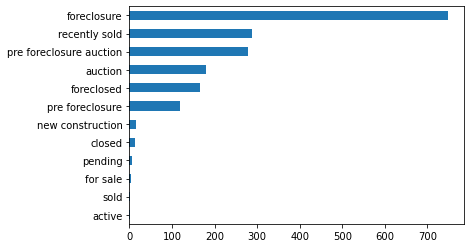

In [2035]:
df_test['status'].value_counts(ascending=True).plot.barh()

In [2036]:
# Заменим null значения
most_stat = df_test['status'].value_counts().index[0]

df_test.loc[df_test['status'].isna(), 'status'] = most_stat

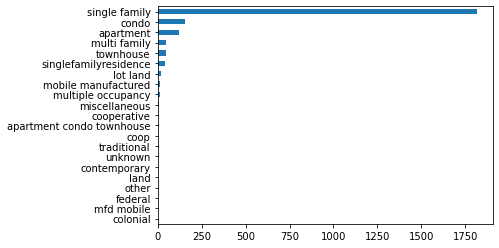

In [2037]:
df_test['propertyType'].value_counts(ascending=True).plot.barh()

In [2038]:
# Заменим null значения
most_prop = df_test['propertyType'].value_counts().index[0]

df_test.loc[df_test['propertyType'].isna(), 'propertyType'] = most_prop

In [2039]:
df_test.loc[df_test['city'].isna(), 'city'] = 'other'

In [2040]:
mean_sqft = round(df_test['sqft'].dropna().mean())

df_test.loc[df_test['sqft'].isna(), 'sqft'] = mean_sqft

In [2041]:
mean_dist_max = round(df_test['dist_max'].dropna().mean())

df_test.loc[df_test['dist_max'].isna(), 'dist_max'] = mean_dist_max

In [2042]:
mean_dist_min = round(df_test['dist_min'].dropna().mean())

df_test.loc[df_test['dist_min'].isna(), 'dist_min'] = mean_dist_min

In [2043]:
mean_dist_mean = round(df_test['dist_mean'].dropna().mean())

df_test.loc[df_test['dist_mean'].isna(), 'dist_mean'] = mean_dist_mean

In [2044]:
mean_rate_max = round(df_test['rate_max'].dropna().mean())

df_test.loc[df_test['rate_max'].isna(), 'rate_max'] = mean_rate_max

In [2045]:
mean_rate_min = round(df_test['rate_min'].dropna().mean())

df_test.loc[df_test['rate_min'].isna(), 'rate_min'] = mean_rate_min

In [2046]:
mean_rate_mean = round(df_test['rate_mean'].dropna().mean())

df_test.loc[df_test['rate_mean'].isna(), 'rate_mean'] = mean_rate_mean

In [2047]:
# Дополнительно выделить столбцы с Null значениями

Обработка финального датасета

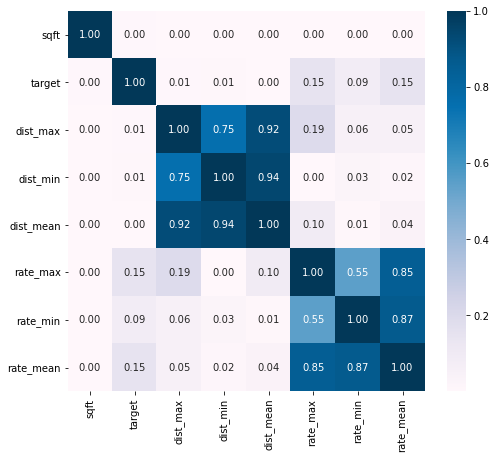

In [2048]:
# Рассмотрим матрицу корреляции для начального удаления сильно скоррелированных признаков

plt.figure(figsize=(8,7))

sns.heatmap(df_train.corr().abs(), annot=True, fmt='.2f', cmap='PuBu')
plt.yticks(rotation=0)
plt.show()

In [2049]:
# Удаляем mean значения из dist и rate
# Пока без токенайзера, поэтому не будем включать столбец street
# Задаем типы переменных

categorical_features = ['status', 'propertyType', 'city', 'zipcode', 'state']
numerical_features = ['sqft', 'dist_max', 'dist_min', 'rate_max', 'rate_min']
value = ['target']

In [2050]:
# Смотрим выбросы

data_out = data_outlier(numerical_features + value, df_train)
data_out

,count,min,mean,max,low_range,upper_range,out_count
name,,,,,,,
sqft,290422.0,0.00,20540.00,7.959794e+08,-1060.00,5196.00,26917.0
dist_max,290422.0,0.02,4.69,1.591090e+03,-3.73,10.56,27791.0
dist_min,290422.0,0.01,1.19,1.590380e+03,-1.04,2.68,24800.0
rate_max,290422.0,1.00,6.63,1.000000e+01,0.50,12.50,0.0
rate_min,290422.0,1.00,3.66,1.000000e+01,-2.50,9.50,548.0
target,290422.0,1.00,613918.69,1.950000e+08,-391066.88,1151280.12,27776.0


Рассмотрим числовые признаки по-отдельности

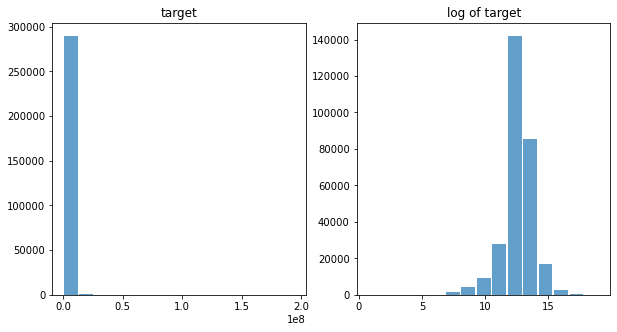

In [2051]:
# target

train_hist_plot('target', df_train)

In [2052]:
df_train['target_log'] = np.log(df_train['target'] + 1)
df_test['target_log'] = 0

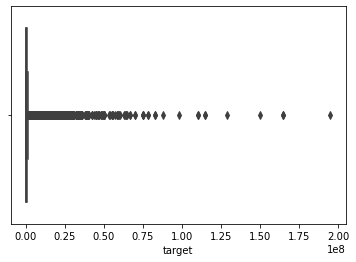

,count,min,mean,max,low_range,upper_range,out_count
target,290422.0,1.0,613918.69,195000000.0,-391066.88,1151280.12,27776.0


In [2053]:
# График выбросов
sns.boxplot(x=df_train["target"])
plt.show()

# Выбросы
data_out.loc['target'].to_frame().T

In [2054]:
# Убираем выбросы
# low_r = data_out.loc['target', 'low_range']
# upp_r = data_out.loc['target', 'upper_range']

# df_train = df_train[(df_train['target'] >= low_r) & (df_train['target'] <= upp_r)]

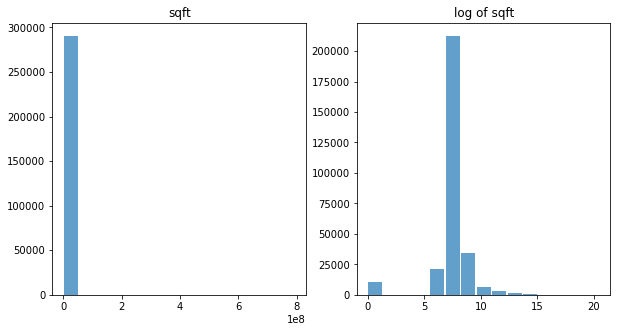

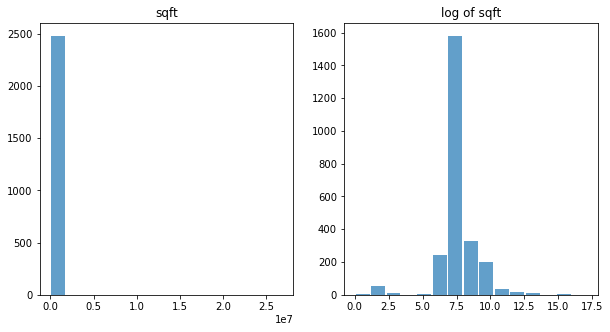

In [2055]:
# sqft
train_hist_plot('sqft', df_train)
test_hist_plot('sqft', df_test)

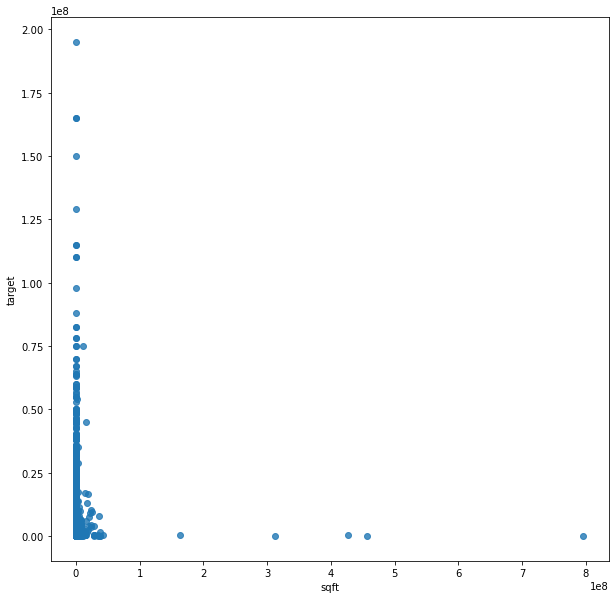

In [2056]:
plt.figure(figsize = (10,10))
sns.regplot(data=df_train, y="target", x="sqft", fit_reg=False)
plt.show()

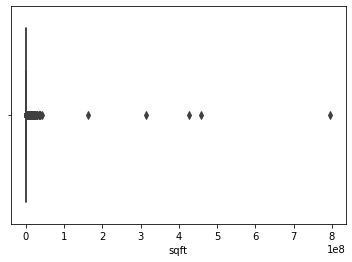

,count,min,mean,max,low_range,upper_range,out_count
sqft,290422.0,0.0,20540.0,795979430.0,-1060.0,5196.0,26917.0


In [2057]:
# График выбросов
sns.boxplot(x=df_train["sqft"])
plt.show()

# Выбросы
data_out.loc['sqft'].to_frame().T

In [2058]:
# Удаляем предварительно ненужное
# df_train = df_train[df_train['sqft'] < 10_000_000]

In [2059]:
# Удаляем выбросы

# low_r = data_out.loc['sqft', 'low_range']
# upp_r = data_out.loc['sqft', 'upper_range']

# df_train = df_train[(df_train['sqft'] >= low_r) & (df_train['sqft'] <= upp_r)]

In [2060]:
df_train['sqft_log'] = np.log(df_train['sqft'] + 1)
df_test['sqft_log'] = np.log(df_test['sqft'] + 1)

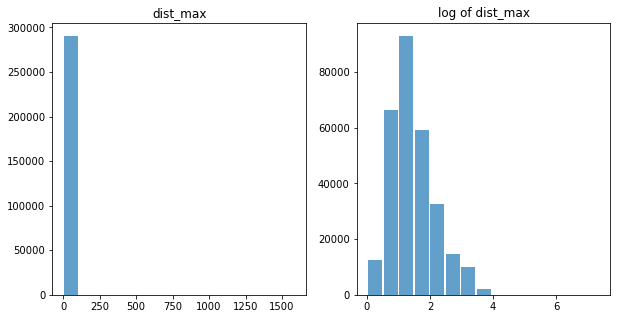

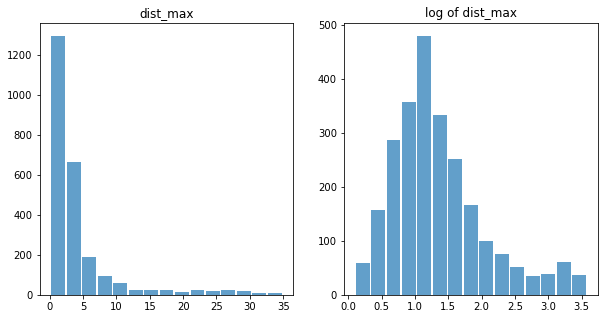

In [2061]:
# dist_max

train_hist_plot('dist_max', df_train)
test_hist_plot('dist_max', df_test)

In [2062]:
df_train['dist_max_log'] = np.log(df_train['dist_max'] + 1)
df_test['dist_max_log'] = np.log(df_test['dist_max'] + 1)

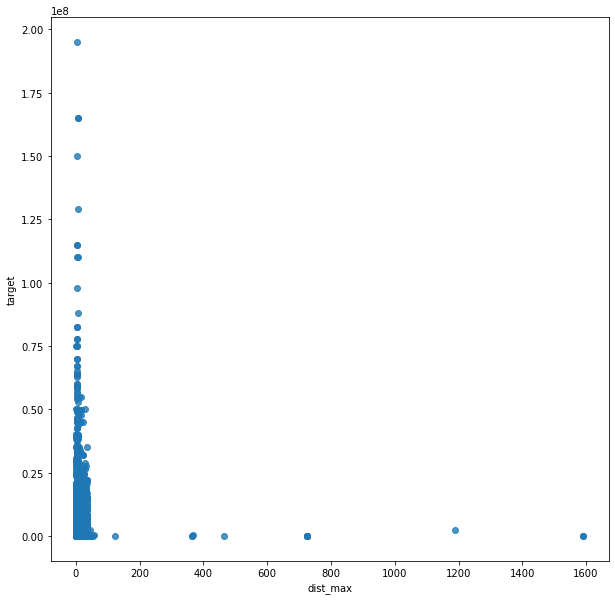

In [2063]:
plt.figure(figsize = (10,10))
sns.regplot(data=df_train, y="target", x="dist_max", fit_reg=False)
plt.show()

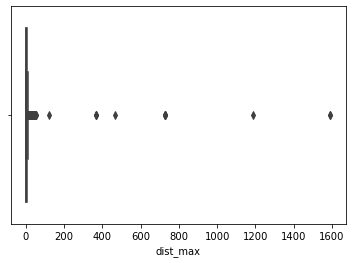

,count,min,mean,max,low_range,upper_range,out_count
dist_max,290422.0,0.02,4.69,1591.09,-3.73,10.56,27791.0


In [2064]:
# График выбросов
sns.boxplot(x=df_train["dist_max"])
plt.show()

# Выбросы
data_out.loc['dist_max'].to_frame().T

In [2065]:
# Удаляем предварительно ненужное

# df_train = df_train[df_train['dist_max'] < 40]

In [2066]:
# Удалим выбросы

# low_r = data_out.loc['dist_max', 'low_range']
# upp_r = data_out.loc['dist_max', 'upper_range']

# df_train = df_train[(df_train['dist_max'] >= low_r) & (df_train['dist_max'] <= upp_r)]

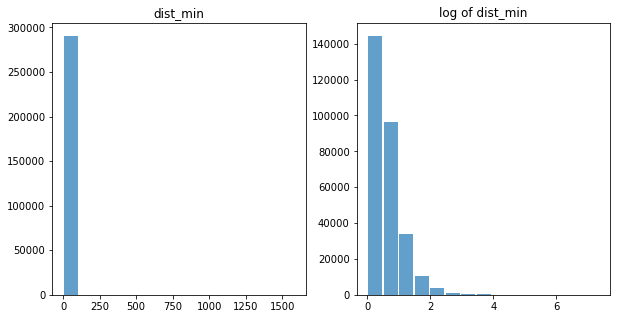

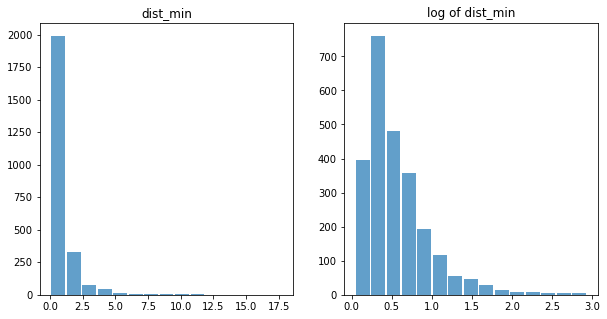

In [2067]:
# dist_min

train_hist_plot('dist_min', df_train)
test_hist_plot('dist_min', df_test)

In [2068]:
df_train['dist_min_log'] = np.log(df_train['dist_min'] + 1)
df_test['dist_min_log'] = np.log(df_test['dist_min'] + 1)

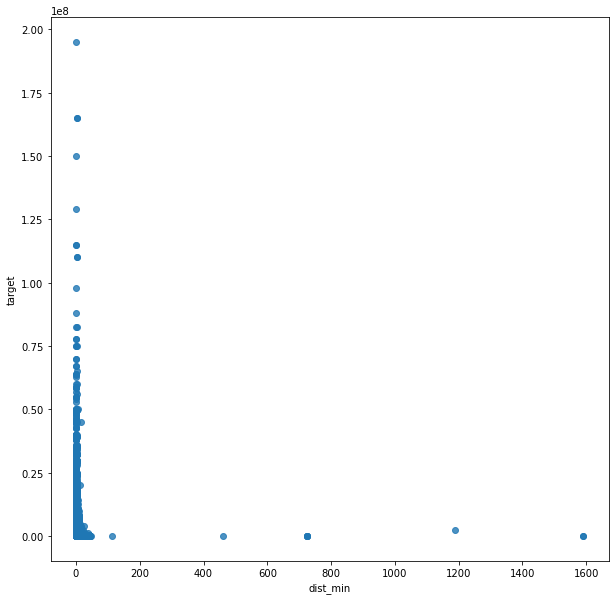

In [2069]:
plt.figure(figsize = (10,10))
sns.regplot(data=df_train, y="target", x="dist_min", fit_reg=False)
plt.show()

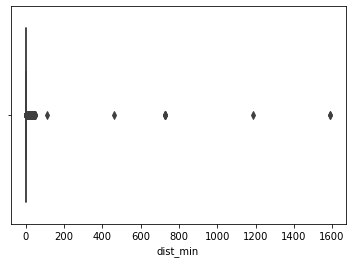

,count,min,mean,max,low_range,upper_range,out_count
dist_min,290422.0,0.01,1.19,1590.38,-1.04,2.68,24800.0


In [2070]:
# График выбросов
sns.boxplot(x=df_train["dist_min"])
plt.show()

# Выбросы
data_out.loc['dist_min'].to_frame().T

In [2071]:
# Удаляем предварительно ненужное

# df_train = df_train[df_train['dist_min'] < 30]

In [2072]:
# Удалим выбросы

# low_r = data_out.loc['dist_min', 'low_range']
# upp_r = data_out.loc['dist_min', 'upper_range']

# df_train = df_train[(df_train['dist_min'] >= low_r) & (df_train['dist_min'] <= upp_r)]

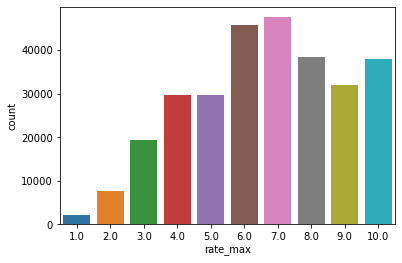

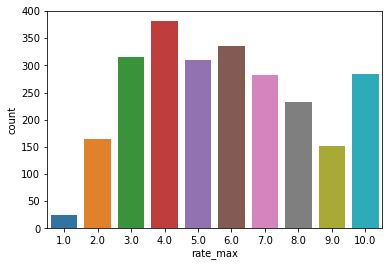

In [2073]:
# rate_max

sns.countplot(x=df_train["rate_max"], data=df_train)
plt.show()

sns.countplot(x=df_test["rate_max"], data=df_test)
plt.show()

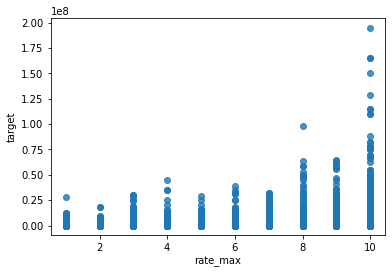

In [2074]:
sns.regplot(data=df_train, y="target", x="rate_max", fit_reg=False)
plt.show()

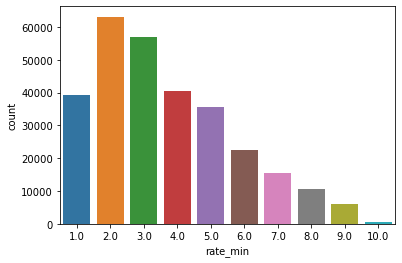

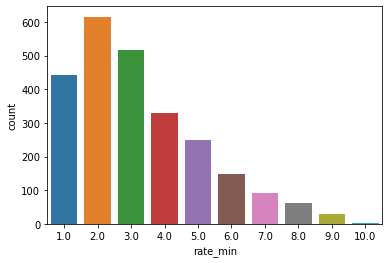

In [2075]:
# rate_min

sns.countplot(x=df_train["rate_min"], data=df_train)
plt.show()

sns.countplot(x=df_test["rate_min"], data=df_test)
plt.show()

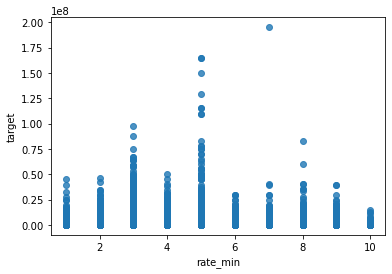

In [2076]:
sns.regplot(data=df_train, y="target", x="rate_min", fit_reg=False)
plt.show()

In [2077]:
# Работа с таргетом 

In [2078]:
# Удаляем предварительно ненужное

# df_train = df_train[df_train['target'] < ]

Влияние числовых признаков на target

In [2079]:
# df_train.columns

In [2080]:
# Введем новые числовые признаки
numerical_features_new = numerical_features + ['dist_max_log', 'dist_min_log' ,'sqft_log']

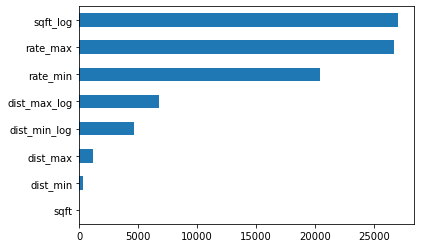

In [2081]:
# График влияния числовых переменных на target

df_train_imp = df_train.copy()

# рассмотрим значимость переменных

imp_num = pd.Series(f_regression(df_train_imp[numerical_features_new], 
                              df_train_imp['target_log'])[0], index=numerical_features_new)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [2082]:
# Видим что наибольшее значение имеет sqft_log, наименьшее sqft

In [2083]:
# График влияния числовых переменных на target

# df_train_imp = df_train.copy()

# # рассмотрим значимость переменных
# label_encoder = LabelEncoder()

# imp_num = pd.Series(mutual_info_regression(df_train_imp[numerical_features_new], 
#                               df_train_imp['target_log']), index=numerical_features_new)
# imp_num.sort_values(inplace = True)
# imp_num.plot(kind = 'barh')

# Рассмаотрим категориальные переменные

In [2084]:
df_train['status'].value_counts()

for sale                                193263
active                                   68337
foreclosure                               5864
new construction                          5207
pending                                   4616
                                         ...  
contingent financing                         1
pending w escape clause                      1
under contract taking back up offers         1
pending backup offer requested               1
lease purchase                               1
Name: status, Length: 95, dtype: int64

In [2085]:
df_test['status'].value_counts()

foreclosure                1410
recently sold               287
pre foreclosure auction     279
auction                     180
foreclosed                  165
pre foreclosure             119
new construction             16
closed                       13
pending                       5
for sale                      4
sold                          2
active                        1
Name: status, dtype: int64

In [2086]:
unique_train_stat = df_train['status'].unique()

df_test[~df_test['status'].isin(unique_train_stat)]['status'].value_counts()

recently sold    287
sold               2
Name: status, dtype: int64

In [2087]:
# Так как в трейне нет ничего похожего на sold, заменим на "for sale"

df_test.loc[df_test['status'].str.contains('sold'), 'status'] = 'for sale'


In [2088]:
unique_stat = df_test['status'].unique()

# Удаляем данные из трейна те значения, которых нет в тесте
df_train = df_train[df_train['status'].isin(unique_stat)]

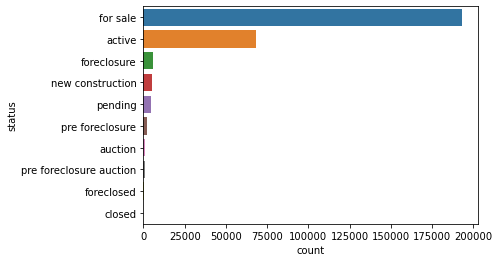

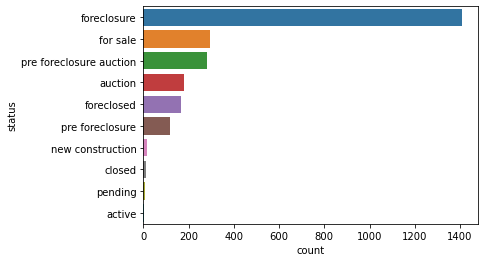

In [2089]:
# Рассмотрим как распределены статусы

sns.countplot(y="status", data=df_train, order = df_train['status'].value_counts().index)
plt.show()

sns.countplot(y="status", data=df_test, order = df_test['status'].value_counts().index)
plt.show()

In [2090]:
df_train['propertyType'].value_counts()

single family                                   153843
condo                                            31689
lot land                                         19548
townhouse                                        14899
multi family                                     10453
                                                 ...  
single detached craftsman mid century modern         1
condo town contemporary modern split level           1
townhouse interior                                   1
historic vintage multi family                        1
expanded ranch                                       1
Name: propertyType, Length: 1065, dtype: int64

In [2091]:
df_test['propertyType'].value_counts()

single family                1994
condo                         157
apartment                     124
multi family                   48
townhouse                      48
singlefamilyresidence          41
lot land                       20
mobile manufactured            15
multiple occupancy             13
miscellaneous                   8
cooperative                     2
apartment condo townhouse       2
coop                            1
traditional                     1
unknown                         1
contemporary                    1
land                            1
other                           1
federal                         1
mfd mobile                      1
colonial                        1
Name: propertyType, dtype: int64

In [2092]:
unique_train_type = df_train['propertyType'].unique()

df_test[~df_test['propertyType'].isin(unique_train_type)]['propertyType'].value_counts()

apartment condo townhouse    2
Name: propertyType, dtype: int64

In [2093]:
# Так как количетсво этих значений мало, заменим на аналогичное из теста

df_test.loc[df_test['propertyType'] == 'apartment condo townhouse', 'propertyType'] = 'apartment'

In [2094]:
unique_type = df_test['propertyType'].unique()

# Удалим строки из трейна, где нет значений из теста
df_train = df_train[df_train['propertyType'].isin(unique_type)]

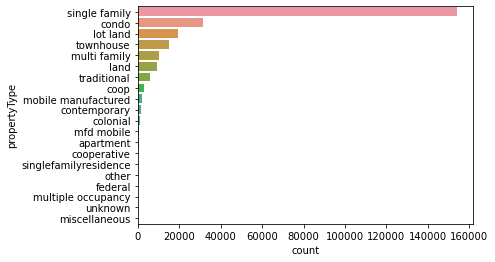

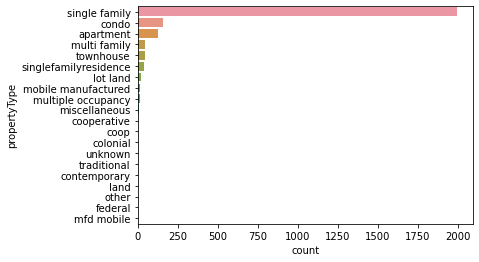

In [2095]:
# Посмотрим как распределены значения в трейне и тесте

sns.countplot(y="propertyType", data=df_train, order = df_train['propertyType'].value_counts().index)
plt.show()

sns.countplot(y="propertyType", data=df_test, order = df_test['propertyType'].value_counts().index)
plt.show()

In [2096]:
# В дальнейшем можно будет упростить значения, чтобы не было такого разброса

In [2097]:
df_train['city'].value_counts()

san antonio    17019
houston        13777
chicago         6470
las vegas       5841
miami           5812
               ...  
germantown         1
belllingham        1
millican           1
bexar co           1
bedias             1
Name: city, Length: 1576, dtype: int64

In [2098]:
df_test['city'].value_counts()

san antonio      134
tampa            125
jacksonville     123
miami            113
washington        89
                ... 
adams              1
york               1
yuba               1
alamo heights      1
gulfport           1
Name: city, Length: 353, dtype: int64

In [2099]:
unique_train_city = df_train['city'].unique()

df_test[~df_test['city'].isin(unique_train_city)]['city'].value_counts()

sisters           1
blythe            1
salineville       1
china             1
sweetwater        1
unincorporated    1
Name: city, dtype: int64

In [2100]:
# Так как мало значений, заменим их всех на other, которое уже присутствует

df_test.loc[~df_test['city'].isin(unique_train_city),'city'] = 'other'


In [2101]:
# Удалим из трейна строки, где значений нет в тесте

unique_city = df_test['city'].unique()

df_train = df_train[df_train['city'].isin(unique_city)]

In [2102]:
# Возможно 
unique_city_name = df_test['city'].value_counts()[df_test['city'].value_counts() < 10].index

for name in unique_city_name:
    df_train.loc[df_train['city'] == name,'city'] = 'other'
    df_test.loc[df_test['city'] == name,'city'] = 'other'


In [2103]:
# Нужно беднт сократить количество уникальных значений, их все равно слишком много!

In [2104]:
df_train['zipcode'].value_counts()

32137    1936
32164    1071
33131     851
77845     837
34746     787
         ... 
01103       1
01608       1
02140       1
77842       1
22039       1
Name: zipcode, Length: 2895, dtype: int64

In [2105]:
df_test['zipcode'].value_counts()

20019    22
33647    20
11201    19
32209    18
33712    17
         ..
94087     1
78023     1
38117     1
77043     1
11230     1
Name: zipcode, Length: 1163, dtype: int64

In [2106]:
# Так как количество уникальных значений слишком много, разделим из согласно правилу 3-2

df_train.loc[:,'zip_f'] = df_train['zipcode'].apply(lambda x: str(x)[:3])
df_test.loc[:,'zip_f'] = df_test['zipcode'].apply(lambda x: str(x)[:3])

df_train.loc[:,'zip_s'] = df_train['zipcode'].apply(lambda x: str(x)[3:])
df_test.loc[:,'zip_s'] = df_test['zipcode'].apply(lambda x: str(x)[3:])


In [2107]:
# Удалим те строки в трейне, которых нет в тесте

unique_zipf = df_test['zip_f'].unique()
unique_zips = df_test['zip_s'].unique()

df_train = df_train[df_train['zip_f'].isin(unique_zipf)]
df_train = df_train[df_train['zip_s'].isin(unique_zips)]


In [2108]:
# Нужно будет сократить количество уникальных значений, их сильно много

# Ввести новые признаки в датафрейм

In [2109]:
df_train['state'].value_counts()

FL    56290
TX    45356
CA    15717
NY    13965
NC    13210
TN    11066
WA     8358
NV     7690
IL     7091
OH     6644
GA     5386
PA     4727
CO     3448
MI     3399
DC     2854
IN     2848
OR     2281
MO      718
MA      651
UT      503
MD      128
VT      106
VA       87
ME       42
Name: state, dtype: int64

In [2110]:
df_test['state'].value_counts()

FL    782
TX    428
CA    178
OH    156
NY    140
TN    109
DC     89
IL     87
WA     87
NC     76
GA     64
NV     61
PA     51
MI     35
MO     34
IN     34
CO     27
MA     18
OR     11
UT      4
VT      4
MD      4
ME      1
VA      1
Name: state, dtype: int64

In [2111]:
# Посмотрим каких значений теста нет в трейне

unique_train_state = df_train['state'].unique()

df_test[~df_test['state'].isin(unique_train_state)]['state'].value_counts()

Series([], Name: state, dtype: int64)

In [2112]:
# Удалим те строки в трейне, которых нет в тесте

unique_state = df_test['state'].unique()

df_train = df_train[df_train['state'].isin(unique_state)]


In [2113]:
# Добавим новые категориальные признаки

categorical_features = categorical_features + ['zip_f', 'zip_s']

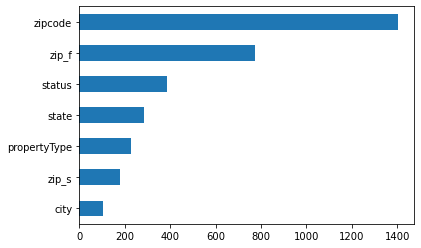

In [2114]:
# Теперь рассмотрим значимость категориальных переменных
df_train_cat = df_train.copy()

label_encoder = LabelEncoder()

for feature in categorical_features:
    df_train_cat[feature] = label_encoder.fit_transform(df_train_cat[feature])

imp_cat = pd.Series(f_regression(df_train_cat[categorical_features], 
                              df_train_cat['target_log'])[0], index=categorical_features)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [2115]:
# Замечание: влияние кат переменных на target и target_log разное

In [2116]:
# # Теперь рассмотрим значимость категориальных переменных

# df_train_cat = df_train.copy()

# # рассмотрим значимость переменных
# label_encoder = LabelEncoder()

# for feature in categorical_features:
#     df_train_cat[feature] = label_encoder.fit_transform(df_train_cat[feature])

# imp_cat = pd.Series(mutual_info_regression(df_train_cat[categorical_features], 
#                               df_train_cat['target_log']), index=numerical_features_new)
# imp_cat.sort_values(inplace = True)
# imp_cat.plot(kind = 'barh')

Prepocess data

In [2117]:
# features = categorical_features + numerical_features_new + ['target_log']
# df_input = pd.concat([df_train[features], df_test[features]])

# Удаляем признаки из numerical_features_new
for x in ['sqft', 'dist_max', 'dist_min', 'rate_max', 'rate_min']:
    numerical_features_new.remove(x)

# Спорный момент
# categorical_features.remove('city')
# categorical_features.remove('zip_s')

categorical_features.remove('zipcode')
for x in ['rate_max', 'rate_min']:
    categorical_features.append(x)
    
features = numerical_features_new + categorical_features + ['target_log']
# features = numerical_features_new + categorical_features + ['target']

In [2118]:
# Мы знаем, что у трейна нет target=0, все эти данные в тесте, поэтому можем легко их оюъединить

df_input = pd.concat([df_train[features], df_test[features]])

In [2119]:
df_input.sample(5)

,dist_max_log,dist_min_log,sqft_log,status,propertyType,city,state,zip_f,zip_s,rate_max,rate_min,target_log
105955,0.828552,0.215111,7.362645,for sale,single family,other,TX,750,60,5.0,3.0,12.323860
178301,2.775086,0.231112,6.704414,for sale,condo,miami,FL,331,65,10.0,5.0,12.013707
238746,1.004302,0.048790,7.716461,foreclosure,multi family,chicago,IL,606,36,2.0,1.0,11.636037
104773,1.633154,0.262364,11.598194,for sale,lot land,fort worth,TX,761,35,7.0,6.0,11.695255
16845,1.088562,0.190620,7.034388,for sale,single family,memphis,TN,381,12,4.0,4.0,11.736077


df_preproc = preproc_data(data)

In [2120]:
df_preproc = preproc_data(df_input, numerical_features_new, categorical_features)

In [2121]:
df_preproc.shape

(215046, 441)

In [2122]:
# Мы видим, что при начальном количестве признаков, количество результирующих признаков слишком большое для теста
# Поэтому мы сразу удалим лишние признаки из трейна
# Возможно, потом удалим выбросы из трейна

Split data

In [2123]:
# Теперь выделим тестовую часть
train_data = df_preproc[df_preproc['target_log'] != 0]
test_data = df_preproc[df_preproc['target_log'] == 0]

X = train_data.drop(['target_log'], axis=1).values
Y = train_data['target_log'].values
X_sub = test_data.drop(['target_log'], axis=1)


# train_data = df_preproc[df_preproc['target'] != 0]
# test_data = df_preproc[df_preproc['target'] == 0]

# X = train_data.drop(['target'], axis=1).values
# Y = train_data['target'].values
# X_sub = test_data.drop(['target'], axis=1)

# CatBoostRegressor

In [2124]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

# Птом можно будет сделать кросс-валидацию

In [2125]:
model = CatBoostRegressor(iterations = 1000,
                          #depth=10,
                          learning_rate = 0.1,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE'],
                          od_wait=100,
                          #task_type='GPU',
                         )

model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )


0:	learn: 0.0655747	test: 0.0651593	best: 0.0651593 (0)	total: 41.4ms	remaining: 41.3s
100:	learn: 0.0356950	test: 0.0355106	best: 0.0355106 (100)	total: 3.3s	remaining: 29.3s
200:	learn: 0.0322635	test: 0.0321498	best: 0.0321498 (200)	total: 5.82s	remaining: 23.1s
300:	learn: 0.0303792	test: 0.0302972	best: 0.0302972 (300)	total: 8.37s	remaining: 19.4s
400:	learn: 0.0291052	test: 0.0291024	best: 0.0291024 (400)	total: 11.3s	remaining: 16.8s
500:	learn: 0.0281678	test: 0.0282536	best: 0.0282536 (500)	total: 14.2s	remaining: 14.1s
600:	learn: 0.0274170	test: 0.0275788	best: 0.0275788 (600)	total: 17s	remaining: 11.3s
700:	learn: 0.0267629	test: 0.0270118	best: 0.0270118 (700)	total: 20s	remaining: 8.53s
800:	learn: 0.0262153	test: 0.0265380	best: 0.0265380 (800)	total: 22.9s	remaining: 5.69s
900:	learn: 0.0257456	test: 0.0261460	best: 0.0261460 (900)	total: 25.8s	remaining: 2.83s
999:	learn: 0.0253278	test: 0.0258003	best: 0.0258003 (999)	total: 28.6s	remaining: 0us

bestTest = 0.025800

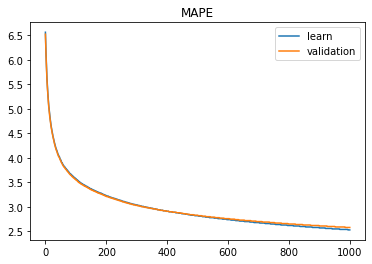

In [2126]:
# model.evals_result_['learn']['MAPE']
# validation

learn_mape = [round(x * 100, 2) for x in model.evals_result_['learn']['MAPE']]
valid_mape = [round(x * 100, 2) for x in model.evals_result_['validation']['MAPE']]

# plt.figure(figsize=(15, 7))
plt.title('MAPE')
plt.plot(learn_mape, label='learn')
plt.plot(valid_mape, label='validation')
plt.legend()
plt.show()




In [2127]:
y_pred = model.predict(X_test)

# print(f"TEST mape: {(mape(y_test, y_pred))*100:0.2f}%")

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 39.92%


In [869]:
# Смещение и дисперсия

# mse = round(np.mean(np.square(y_test_exp - y_pred_exp)))
# rmse = round(np.sqrt(mse))

# var = round(np.var(y_pred_exp))
# bias = round(np.mean(y_pred_exp - y_test_exp))

# print("MSE result:", mse)
# print("RMSE result:", rmse)
# print("VAR result:", var)
# print("bias result:", bias)
# print("Decomposed result:", var + bias*bias)

In [870]:
price_out = pd.DataFrame(list(zip(y_pred_exp, y_test_exp)), columns = ['y_pred_exp', 'y_test_exp'])
# price_out.to_csv('price_out.csv')